In [1]:
# 防止预分配内存
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps_wyl import Place_net, Grid_net
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import os
import random

# 设置随机种子
seed = 3
np.random.seed(seed)
bm.random.seed(seed)
random.seed(seed)

In [2]:
z_min = 0
z_max = 20
place_num = 800
grid_num = 20
module_num = 10
map_num = 20
a_p = 0.5
Spacing = np.linspace(6,20,module_num)

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=place_num, place_num=place_num, noise_stre=0.5)
maps = bm.as_numpy(Place_cell.map) 
place_index = bm.as_numpy(Place_cell.place_index) 


Gird_module_list = bm.NodeList([])
for module in range(module_num):
    Grid_cell = Grid_net(L = Spacing[module], maps=maps, place_index=place_index, neuron_num=grid_num, J0=5, a_g=a_p/Spacing[module]*2*bm.pi, W0=0.05)
    Gird_module_list.append(Grid_cell)

conn_out = Grid_cell.conn_out

  0%|          | 0/20000 [00:00<?, ?it/s]

4
0.10832564532756805


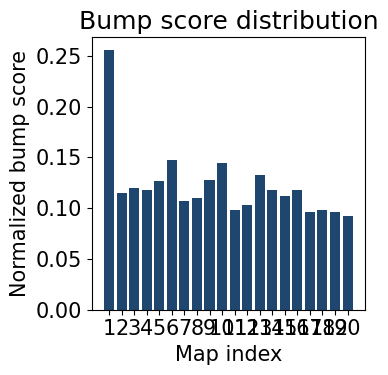

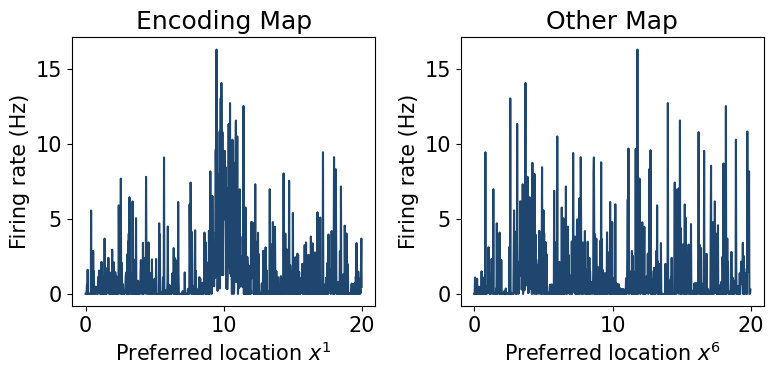

In [3]:
z0 = 10
map_index = 0
I_per = 20 # 修改项

# 初始化网络
def initialize(indices, input_stre):
    output = bm.zeros(place_num,)
    for Grid_cell in Gird_module_list:
        Grid_cell.step_run(indices, r_hpc= I_per * Place_cell.r, loc=z0, input_stre=input_stre, map_index = map_index)
        output += Grid_cell.output
    Place_cell.step_run(indices, loc=z0, map_index = map_index, input_stre=input_stre, input_g = output * I_per)
    place_r = Place_cell.r
    return output, place_r

total_time = 20000
start_time = 100
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
output, place_r = bm.for_loop(initialize, (indices, input_stre), progress_bar = True)

u = Place_cell.r
loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    score_candidate = np.zeros(loc_num,)
    for j in range(loc_num):
        bump = Place_cell.get_bump(map_index, loc_candidate[j])
        u_place = u_place/bm.sum(u_place)
        score_candidate[j] = bm.sum(bump*u_place)
        bump_score[map_index] = np.max(score_candidate)
    max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})

plt.figure(figsize=(4,4))
plt.bar(np.arange(map_num)+1, bump_score, color=[30/255, 70/255, 110/255])
plt.xticks(np.arange(map_num)+1)
plt.xlabel('Map index')
plt.ylabel('Normalized bump score')
plt.title('Bump score distribution')
plt.tight_layout()
# plt.savefig('./figures/bump_score.pdf')

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})


bump_score_other = bump_score[1:]
index = np.argmax(bump_score_other)
print(index)
print(bump_score[0]-bump_score_other[index])
# 绘图
_, ax = plt.subplots(1, 2, figsize=(2*4, 4))
for map_index in range(2):
    if map_index == 1:
        u_place = place_r[:, place_index[index+1]]
        sorted_indices = np.argsort(maps[index+1])
        sorted_maps = maps[index+1, sorted_indices]
        sorted_u_place = u_place[:, sorted_indices]
        ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
        ax[map_index].set_title(f'Other Map')
        ax[map_index].set_xlabel(r'Preferred location $x^{' + str(index+1+1) + '}$')
        ax[map_index].set_ylabel('Firing rate (Hz)')
    else:
        u_place = place_r[:, place_index[map_index]]
        sorted_indices = np.argsort(maps[map_index])
        sorted_maps = maps[map_index, sorted_indices]
        sorted_u_place = u_place[:, sorted_indices]
        ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
        ax[map_index].set_title(f'Encoding Map')
        ax[map_index].set_xlabel(r'Preferred location $x^{' + str(map_index+1) + '}$')
        ax[map_index].set_ylabel('Firing rate (Hz)')
plt.tight_layout()
# plt.savefig('figures/Bump_states.pdf')


[0.5714414  0.25787547 0.26779497 0.26438498 0.2826052  0.32905242
 0.2399953  0.24520113 0.28671026 0.32374743 0.21902913 0.23103407
 0.29596895 0.2640888  0.25088668 0.26268223 0.21545713 0.21954927
 0.21421312 0.20714849]
0.242389


<BarContainer object of 20 artists>

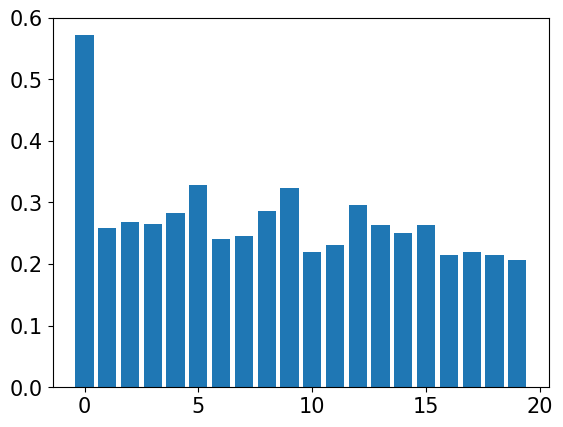

In [4]:
# 第二种计算bump score的方式

import jax
def cosine_similarity(a, b):
    dot_product = jax.numpy.dot(a, b)
    norm_a = jax.numpy.linalg.norm(a)
    norm_b = jax.numpy.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def compute_bump_score(u, loc_candidate, map_num, Place_cell, place_index):
    def body(map_index):
        u_place = u[place_index[map_index]]
        
        def score_func(loc):
            bump = Place_cell.get_bump(map_index, loc) 
            return cosine_similarity(bump, u_place)

        score_candidate = jax.vmap(score_func)(loc_candidate)
        return bm.max(score_candidate)
    bump_score = bm.for_loop(body, (bm.arange(map_num)), progress_bar=False)
    return bump_score

bump_score = compute_bump_score(u, loc_candidate, map_num=map_num, Place_cell=Place_cell, place_index=Place_cell.place_index)
print(bump_score)
print(bump_score[0] - bm.max(bump_score[1:]))
plt.bar(np.arange(map_num), bump_score)



In [ ]:
map_index = 0
recored_list = [[] for _ in range(len(Gird_module_list))]  # Initialize recored_list for each Grid_cell
timestep = 800
z = bm.linspace(0, 20, timestep)
integrate_step = bm.arange(timestep)
I_per = bm.zeros(timestep) 
I_per[:] = 20 # 修改项

def step(integrate_step, I_per):
    # 初始化网络
    def initialize(indices, input_stre):
        output = bm.zeros(place_num,)
        for Grid_cell in Gird_module_list:
            Grid_cell.step_run(indices, r_hpc= I_per * Place_cell.r, loc=z[integrate_step], input_stre=input_stre, map_index = map_index)
            output += Grid_cell.output
        Place_cell.step_run(indices, loc=z[integrate_step], map_index = map_index, input_stre=input_stre, input_g = output * I_per)
        place_r = Place_cell.r
        return output, place_r

    total_time = 20000
    start_time = 100
    indices = bm.arange(total_time)
    input_stre = bm.zeros(total_time) 
    input_stre[:start_time] = 10.
    output, place_r = bm.for_loop(initialize, (indices, input_stre), progress_bar = True)
    return place_r[-1]

record_place_r = bm.for_loop(step, (integrate_step, I_per), progress_bar=True)
# record_place_r_inactivated = bm.for_loop(step, (integrate_step, bm.zeros(timestep)), progress_bar=True)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [6]:
record_place_r_inactivated = record_place_r 

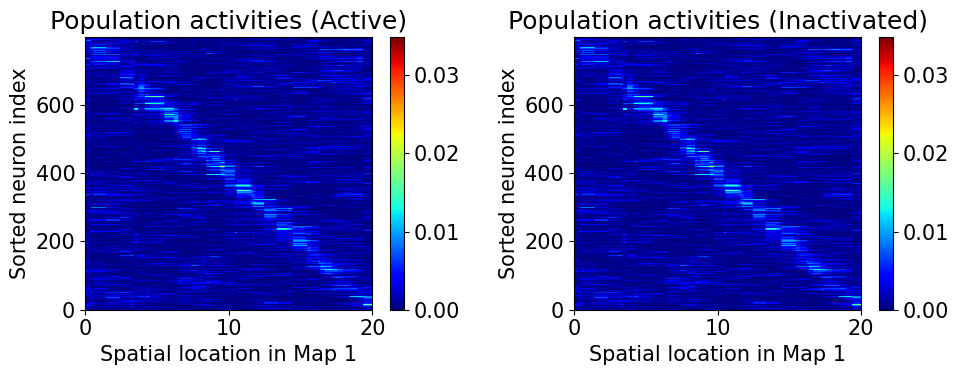

In [7]:
from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# 左图：record_place_r
u_place_active = record_place_r[:, place_index[map_index]]
sorted_indices = np.argsort(maps[map_index])
sorted_maps = maps[map_index, sorted_indices]
sorted_u_place_active = u_place_active[:, sorted_indices]
flipped_sorted_u_place_active = np.flipud(sorted_u_place_active.T)
top_10_percent_active = int(0.1 * flipped_sorted_u_place_active.max(axis=1).size)
top_values_active = np.sort(flipped_sorted_u_place_active.flatten())[-top_10_percent_active:]
vmax_active = top_values_active[0] if len(top_values_active) > 0 else flipped_sorted_u_place_active.max()

# 右图：record_place_r_inactivated
u_place_couple = record_place_r_inactivated[:, place_index[map_index]]
sorted_u_place_couple = u_place_couple[:, sorted_indices]
flipped_sorted_u_place_couple = np.flipud(sorted_u_place_couple.T)
top_10_percent_couple = int(0.1 * flipped_sorted_u_place_couple.max(axis=1).size)
top_values_couple = np.sort(flipped_sorted_u_place_couple.flatten())[-top_10_percent_couple:]
vmax_couple = top_values_couple[0] if len(top_values_couple) > 0 else flipped_sorted_u_place_couple.max()

# 对数据做高斯平滑
smoothed_active = gaussian_filter(flipped_sorted_u_place_active, sigma=1)
smoothed_couple = gaussian_filter(flipped_sorted_u_place_couple, sigma=1)

pcm1 = ax[0].pcolormesh(z, np.arange(place_num), smoothed_active, cmap='jet', vmax=vmax_couple)
fig.colorbar(pcm1, ax=ax[0])
ax[0].set_xlabel('Spatial location in Map 1')
ax[0].set_ylabel('Sorted neuron index')
ax[0].set_title('Population activities (Active)')

pcm2 = ax[1].pcolormesh(z, np.arange(place_num), smoothed_couple, cmap='jet', vmax=vmax_couple)
fig.colorbar(pcm2, ax=ax[1])
ax[1].set_xlabel('Spatial location in Map 1')
ax[1].set_ylabel('Sorted neuron index')
ax[1].set_title('Population activities (Inactivated)')

plt.tight_layout()
plt.show()

In [8]:
np.savez('/home/yulingwu/CCS_place_grid/Storing_multiple_maps/population_activities_0630/data/3_depor.npz',
        sorted_u_place_couple = sorted_u_place_active)

In [7]:
np.savez('/home/yulingwu/CCS_place_grid/Storing_multiple_maps/population_activities_0630/data/3_0701_step800.npz',
        sorted_u_place = sorted_u_place_couple,
        sorted_u_place_couple = sorted_u_place_active)